<a href="https://colab.research.google.com/github/dnaae/minor-internship/blob/FISH-QUANT-pipeline/SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install big-fish

In [ ]:
#imports
import os
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.multistack as multistack
from google.colab import drive
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import re

/usr/local/lib/python3.10/dist-packages/bigfish/segmentation/nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


In [ ]:
# Function to mount Google Drive and select a folder
def choose_folder_colab():
    drive.mount('/content/drive')
    drive_folder = "/content/drive/MyDrive/"
    contents = os.listdir(drive_folder)

    print("Contents of your Google Drive:")
    for i, item in enumerate(contents):
        print(f"{i + 1}: {item}")

    while True:
        choice = input("Enter the number of the folder you want to select (q to quit): ")
        if choice.lower() == 'q':
            return None
        try:
            choice = int(choice)
            if 1 <= choice <= len(contents):
                selected_folder = os.path.join(drive_folder, contents[choice - 1])
                return selected_folder
            else:
                print("Invalid choice. Please try again or enter 'q' to quit.")
        except (ValueError, KeyboardInterrupt):
            print("Invalid input. Please try again or enter 'q' to quit.")

In [ ]:
# Function to create folders for masks
def create_mask_folders(path_output):
    nuclear_mask_folder = os.path.join(path_output, "nuclear masks")
    cellular_mask_folder = os.path.join(path_output, "cellular masks")

    os.makedirs(nuclear_mask_folder, exist_ok=True)
    os.makedirs(cellular_mask_folder, exist_ok=True)

    return nuclear_mask_folder, cellular_mask_folder

In [ ]:
#on smooth image
#cpth2 200 80, 200 and 100 worked better, fulv original 100 70, 130 80 good tsa was 70 for cell and nuc 200, jq1 100-70 mrk 150,65 kdm120 70
def extract_nuclear_mask_and_segment_cells(dapi, smfish, treatment):
    nuc_thresholds = {"5-AZA": 238, "CPTH2": 200, "FULV":130, "DMSO": 150, "MRK-740": 150, "TSA":130, "JQ1":150, "KDM5-C70":120}
    cell_thresholds = {"5-AZA": 100, "CPTH2": 80, "FULV":80, "DMSO": 80, "MRK-740": 65,"TSA":70, "JQ1":100, "KDM5-C70":60}

    if treatment in nuc_thresholds and treatment in cell_thresholds:
        #define nuclear and cellular threshold
        nuc_threshold = nuc_thresholds[treatment]
        cell_threshold = cell_thresholds[treatment]
        #apply gaussian filter-DAPI
        dapi=stack.gaussian_filter(dapi, sigma=5)
        dapi_blur=cv.blur(dapi, (5, 5))
        nuc_mask = segmentation.thresholding(dapi, threshold=nuc_threshold)
        nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=100, fill_holes=True)
        nuc_label = segmentation.label_instances(nuc_mask)
        #apply gaussian filter-smFISH
        smfish=stack.gaussian_filter(smfish, sigma=5)
        smfish_blur = cv.blur(smfish, (5, 5))
        cell_label = segmentation.cell_watershed(smfish_blur, nuc_label, threshold=cell_threshold, alpha=0.9)
        nuc_label = segmentation.clean_segmentation(nuc_label, delimit_instance=True)
        cell_label = segmentation.clean_segmentation(cell_label, smoothness=7, delimit_instance=True)

        return nuc_label, cell_label
    else:
        # Handle the case where thresholds are not defined
        print("Invalid treatment. Please provide a valid treatment name.")
        return None, None

In [ ]:
def process_tiff_image(path_output, dapi_channel_name, smfish_channel_name, selected_image_index, treatment):
    # Construct the full path to the image file within the specified folder
    dapi_path = os.path.join(path_output, "splitted images", dapi_channel_name)
    smfish_path = os.path.join(path_output, "splitted images", smfish_channel_name)
    treatment_parts = top_level_folder.split("_")

    print(f"Extracted treatment: {treatment}")
    # Check if the image files exist before processing
    if not os.path.exists(dapi_path) or not os.path.exists(smfish_path):
        print(f"Image files not found in the specified folder.")
        return
    print(f"DAPI Path: {dapi_path}")
    print(f"smFISH Path: {smfish_path}")
    # Read DAPI and smFISH images
    dapi_3d = stack.read_image(dapi_path)
    dapi = stack.mean_projection(dapi_3d)
    dapi = stack.gaussian_filter(dapi, sigma=5) #apply gaussian filter
    smfish_3d = stack.read_image(smfish_path)
    smfish = stack.mean_projection(smfish_3d)
    smfish= stack.gaussian_filter(smfish, sigma=5) #apply gaussian filter

    #attempt to further denoise
    dapi_log = stack.log_filter(dapi, sigma=3)
    dapi_background_mean = stack.remove_background_mean(dapi, kernel_shape="square", kernel_size=31)
    dapi_background_gaussian = stack.remove_background_gaussian(dapi, sigma=3)
    #images = [rna_log, rna_background_gaussian, rna_background_mean]
    rna_log = stack.log_filter(smfish, sigma=3)
    rna_background_mean = stack.remove_background_mean(smfish, kernel_shape="square", kernel_size=31)
    rna_background_gaussian = stack.remove_background_gaussian(smfish, sigma=3)
    #images = [rna_log, rna_background_gaussian, rna_background_mean]
    # Process the images to obtain nuclear and cellular masks
    nuc_label, cell_label = extract_nuclear_mask_and_segment_cells(dapi, smfish,treatment)

    # Create folders for masks
    nuc_masks_folder, cell_masks_folder = create_mask_folders(path_output)

    # Define the names for the nuclear and cellular masks based on the selected index
    initial_image_index = selected_image_index
    nuc_mask_name = f"nuclear_mask_{initial_image_index}.tif"
    cell_mask_name = f"cellular_mask_{initial_image_index}.tif"

    # Construct the full paths to save the masks in their respective folders
    nuc_mask_path = os.path.join(nuc_masks_folder, nuc_mask_name)
    cell_mask_path = os.path.join(cell_masks_folder, cell_mask_name)

    # Save the masks in the respective folders
    # Rescale and cast to uint8 (assuming 8-bit images)
    # Rescale the pixel values to the range [0, 1]
   # Save the masks in the respective folders with a different datatype
    from skimage import img_as_ubyte

# Convert labels to uint16 before saving
    nuc_label_uint16 = img_as_ubyte(nuc_label)
    cell_label_uint16 = img_as_ubyte(cell_label)

# Save the masks in the respective folders
    # Convert label arrays to uint8
    nuc_label_uint8 = nuc_label.astype(np.uint8)
    cell_label_uint8 = cell_label.astype(np.uint8)

# Save the masks in the respective folders
    stack.save_image(nuc_label_uint8, nuc_mask_path, extension='tif')
    stack.save_image(cell_label_uint8, cell_mask_path, extension='tif')

    # stack.save_image(nuc_label, nuc_mask_path)
    # stack.save_image(cell_label, cell_mask_path)
    print("Nuclear Label Array - Min:", np.min(nuc_label), "Max:", np.max(nuc_label))
    print("Cellular Label Array - Min:", np.min(cell_label), "Max:", np.max(cell_label))
    print(f"Processed image: {dapi_channel_name}")
    print(f"Saved nuclear mask as {nuc_mask_path}")
    print(f"Saved cellular mask as {cell_mask_path}")
    plot.plot_segmentation(dapi, nuc_label, rescale=True)
    plot.plot_segmentation(smfish, cell_label, rescale=True)
    plot.plot_segmentation_boundary(smfish, cell_label, nuc_label, contrast=True)


In [ ]:
def extract_number_from_filename(filename):
    pattern = re.compile(r'(\d{3})\.tif_C\d\.tif')
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    else:
        return float('inf')
#for dmso 1 digit

# def extract_number_from_filename(filename):
#     pattern = re.compile(r'(\d{3})\.tif_C\d\.tif')
#     match = re.search(pattern, filename)
#     if match:
#         # Convert the matched group to an integer
#         num = int(match.group(1))
#         # Format the number to have leading zeros and three digits
#         return f"{num:03d}"
#     else:
#         return float('inf')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_193.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_193.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_193.tif


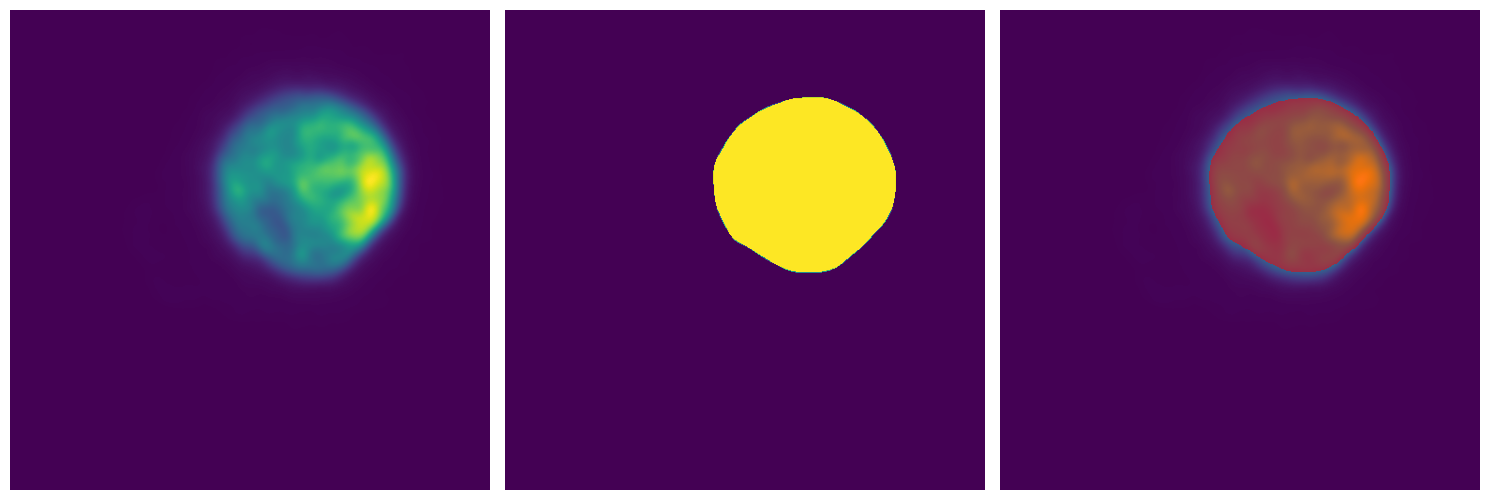

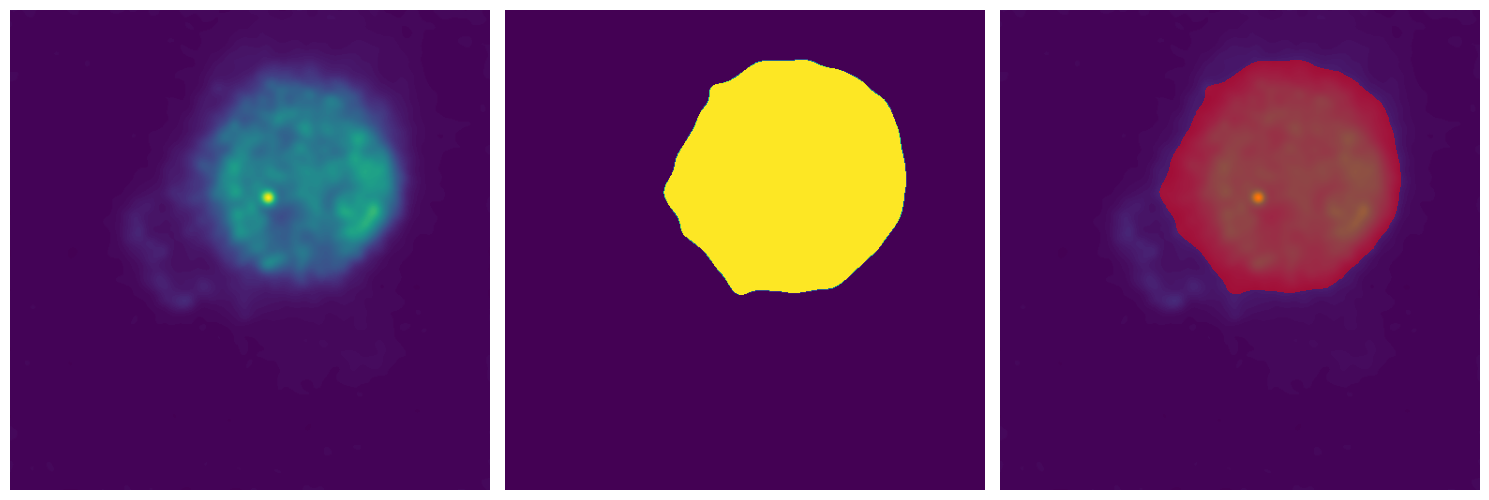

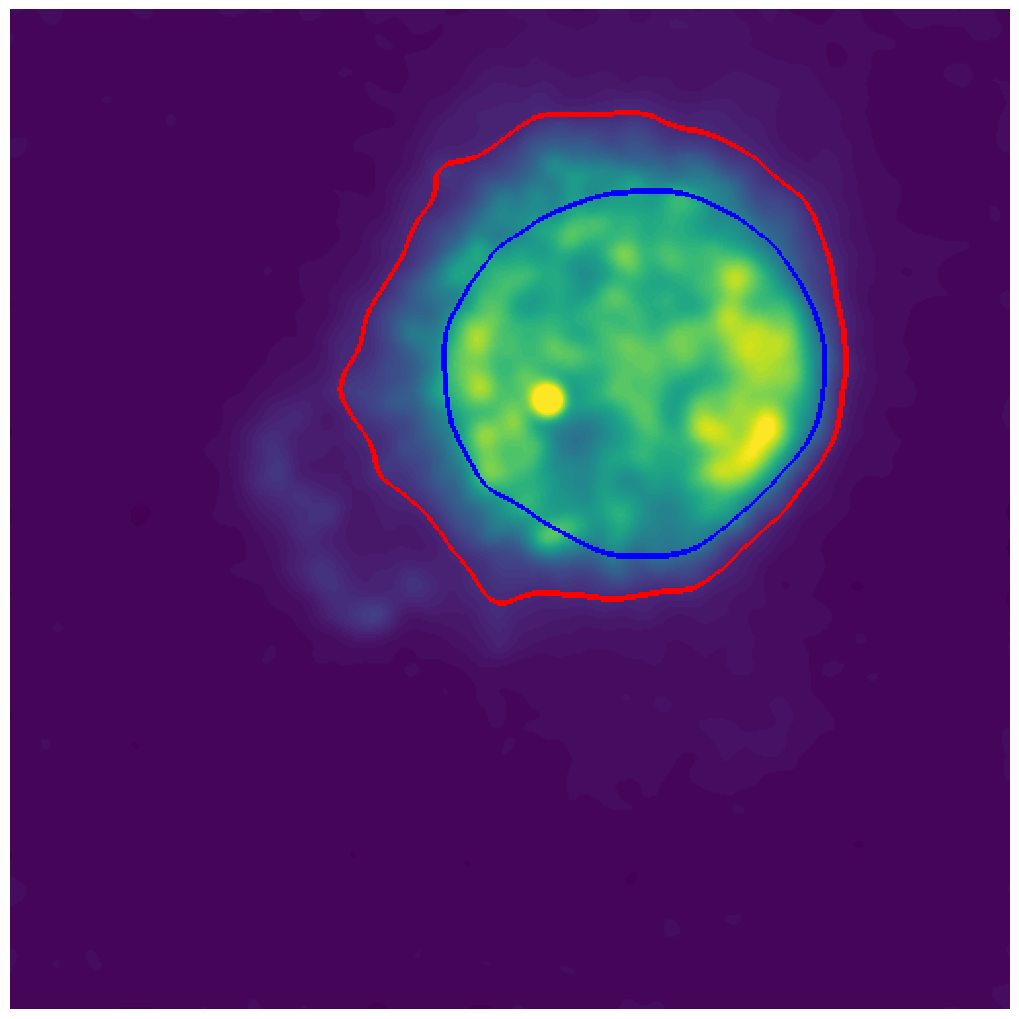

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_194.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_194.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_194.tif


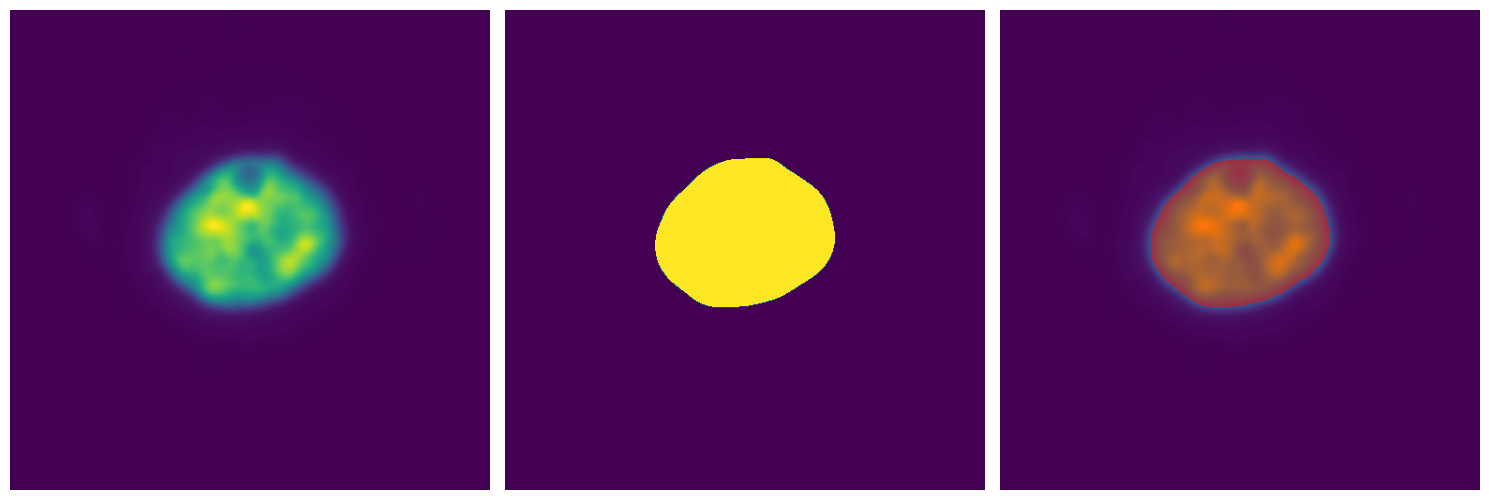

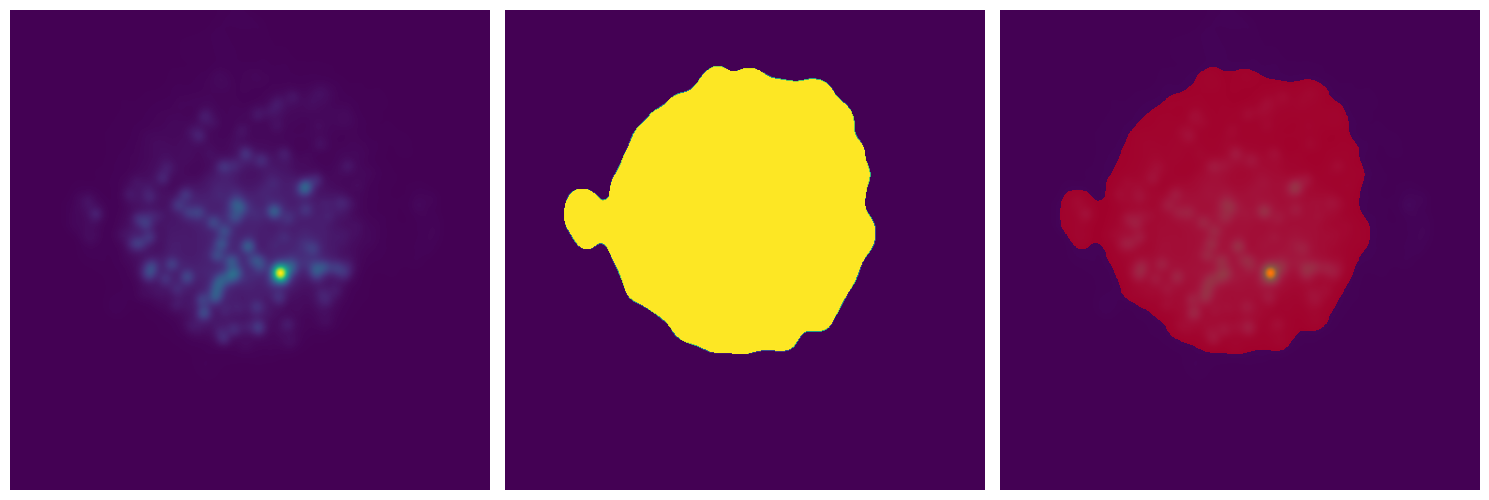

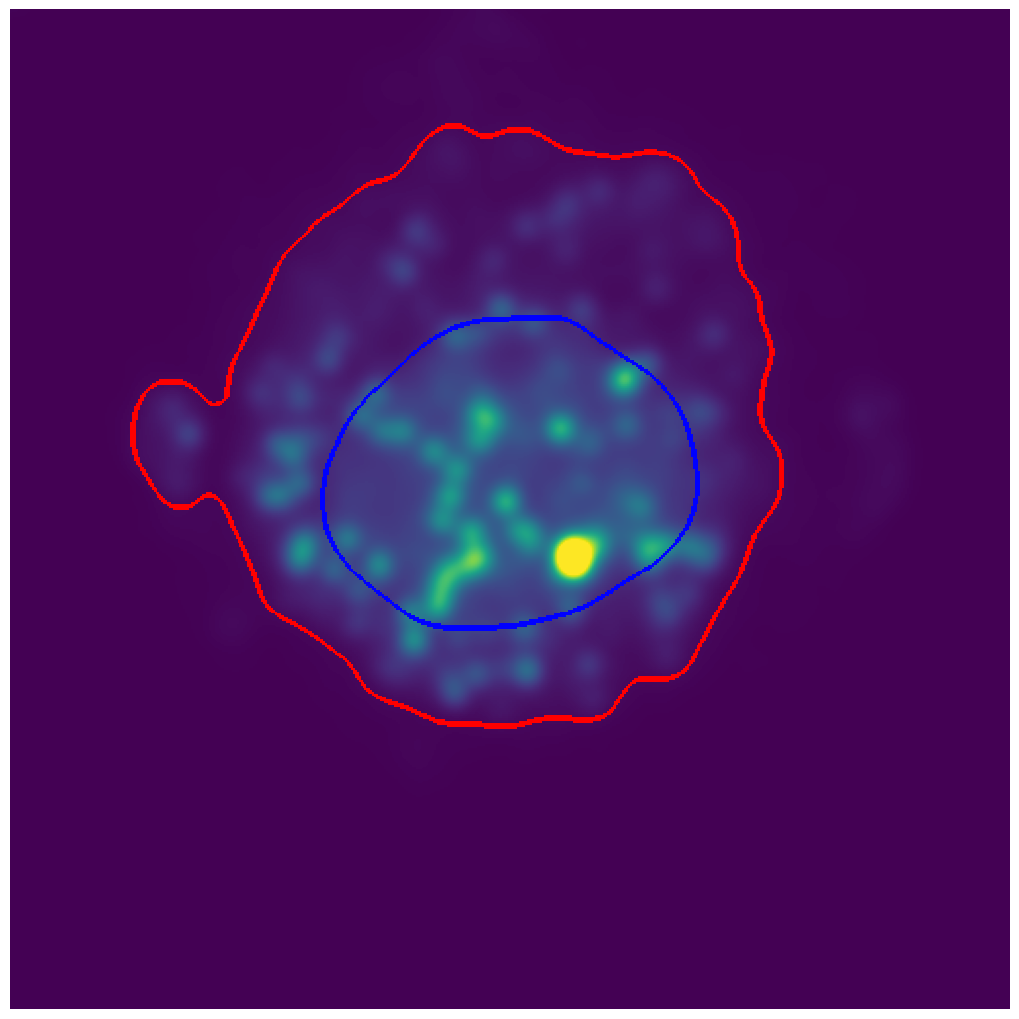

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_195.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_195.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_195.tif


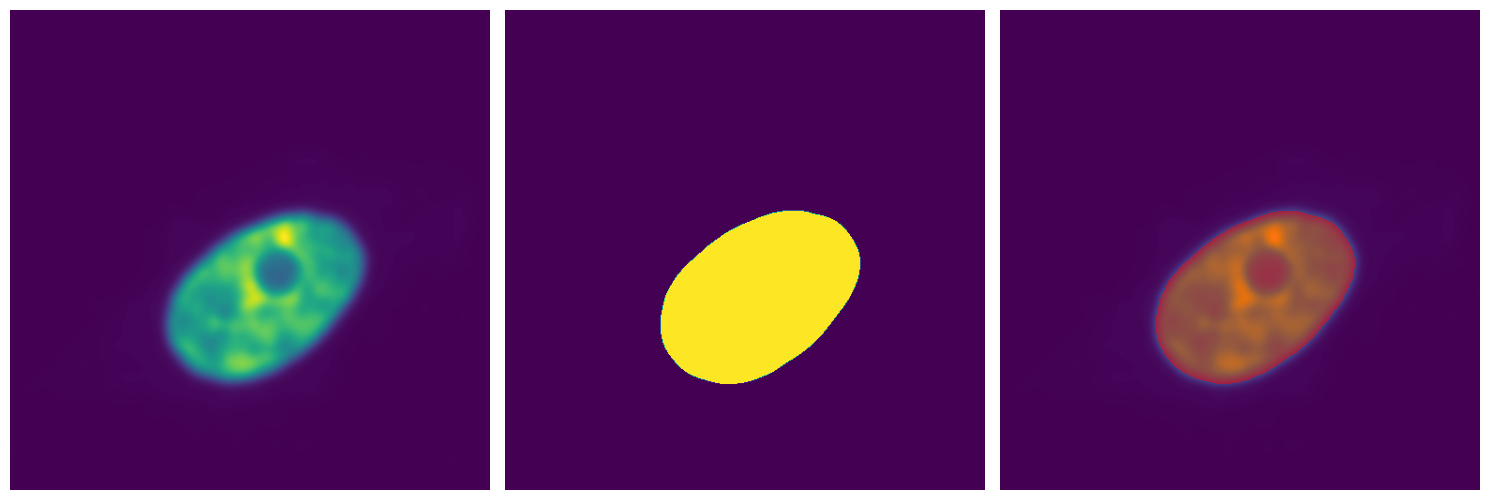

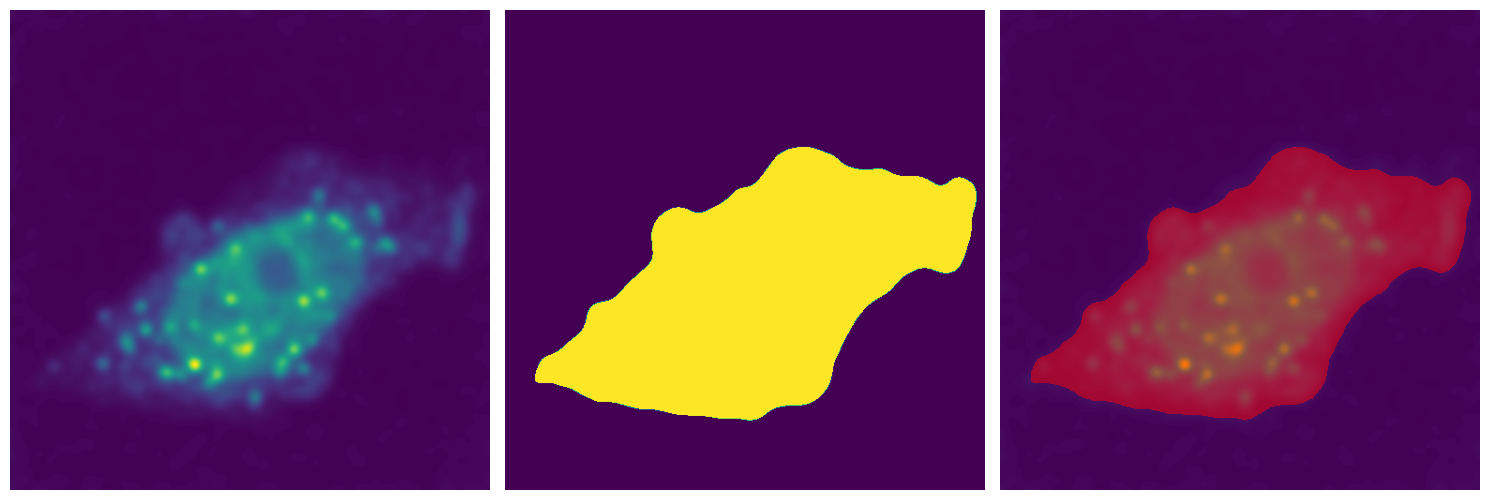

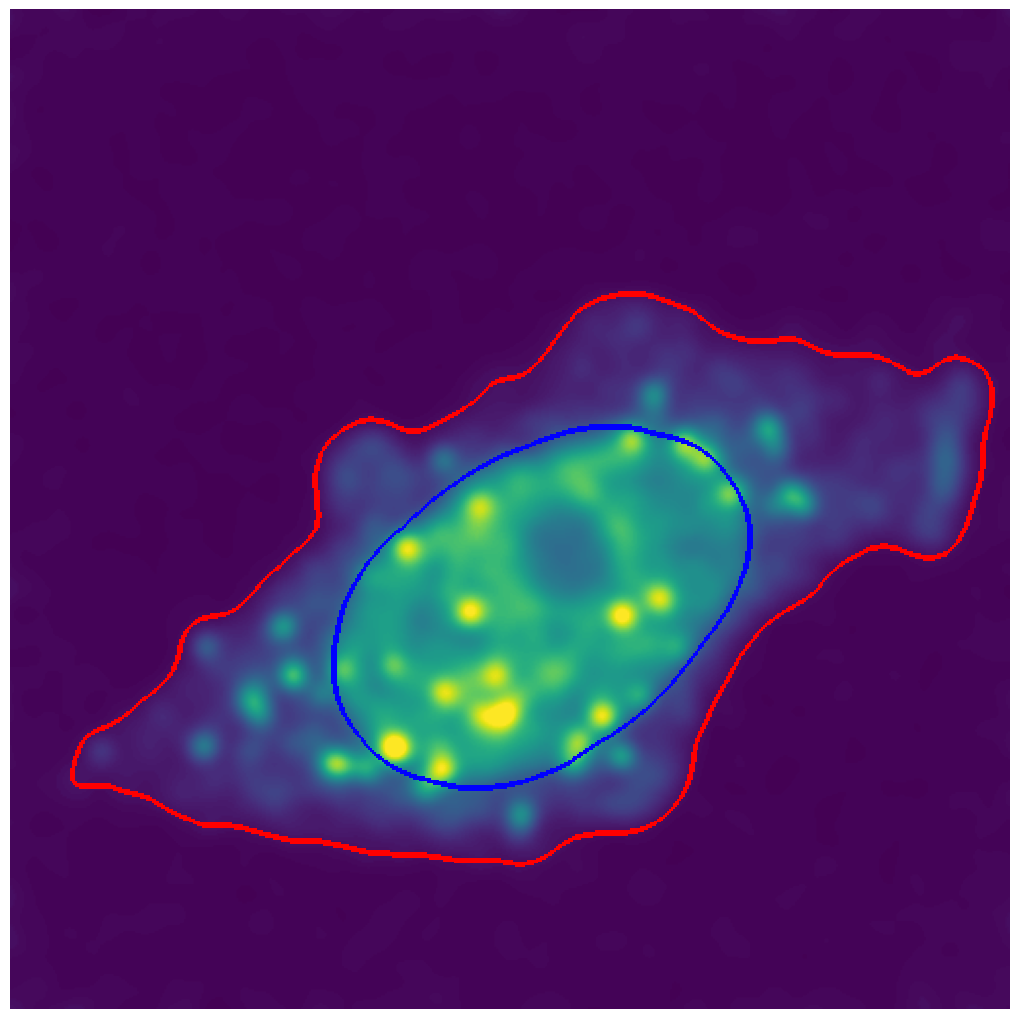

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_196.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_196.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_196.tif


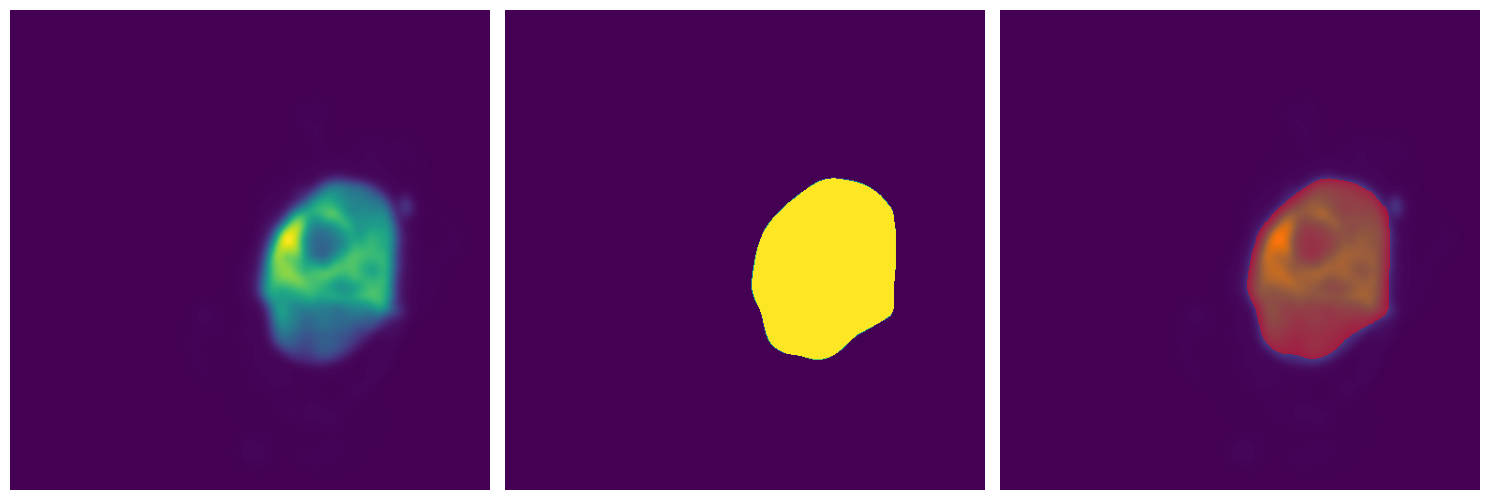

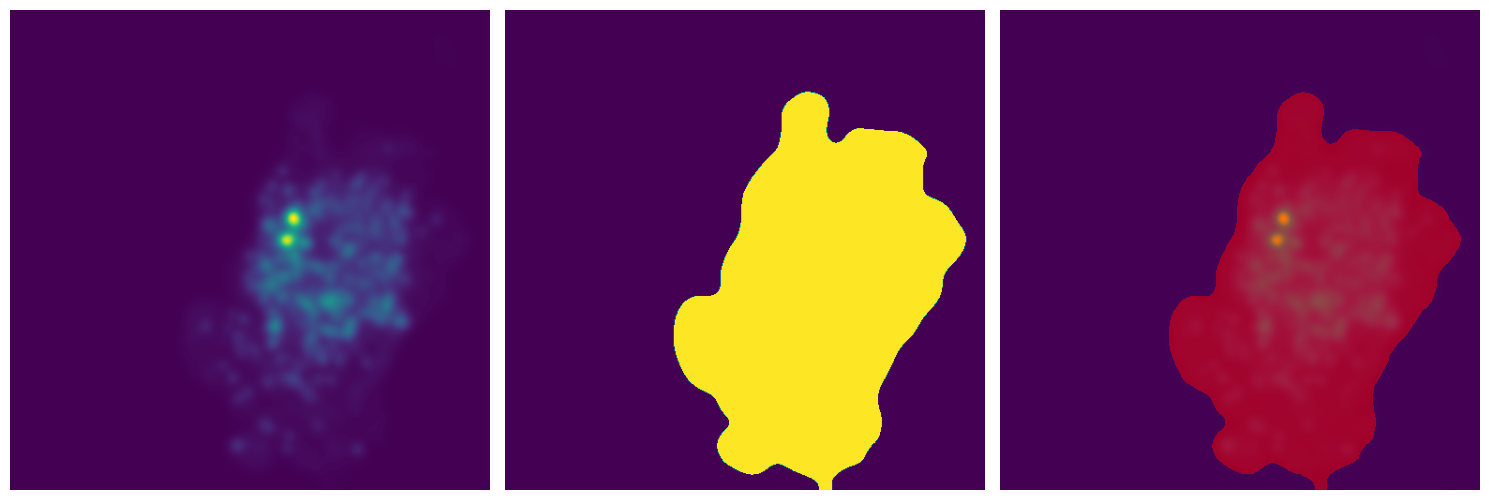

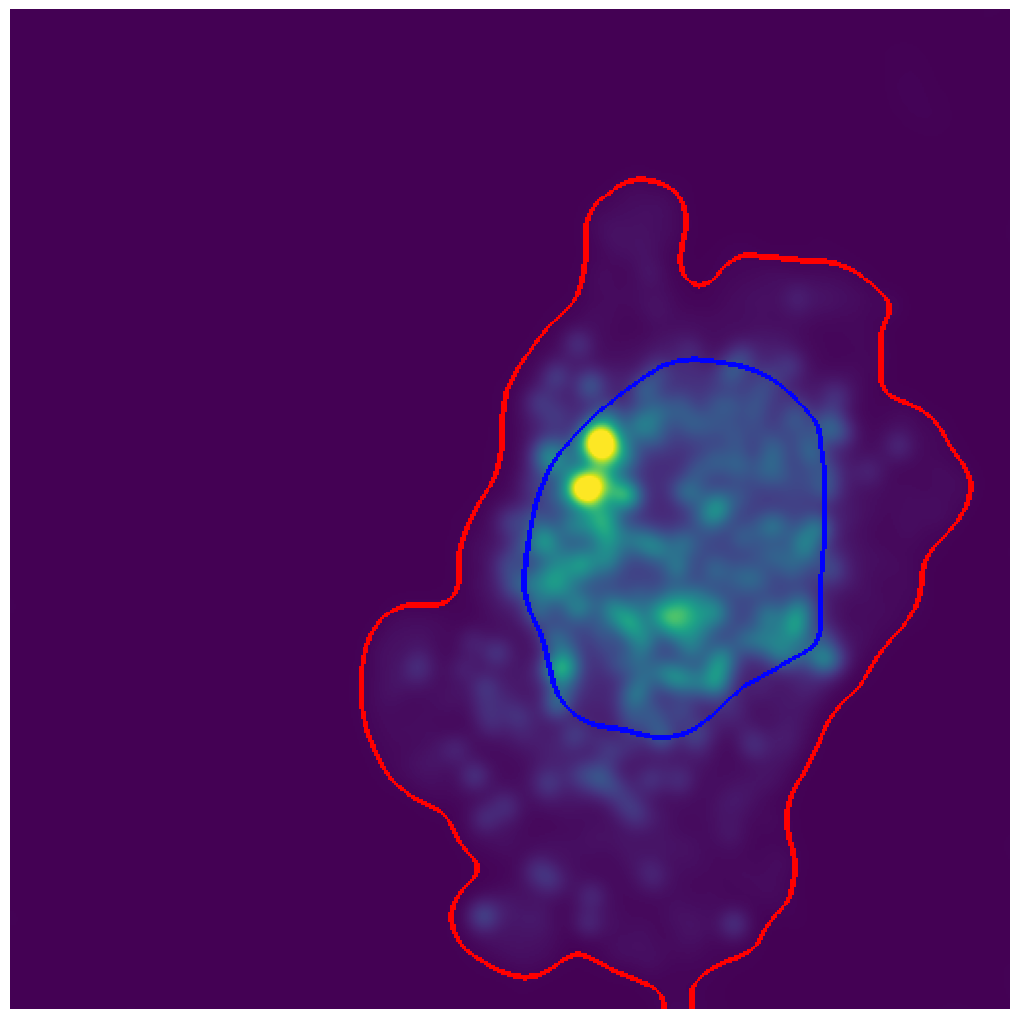

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 11
Invalid subfolder selection. Please try again.
Drive already mounted at /content/drive; to atte

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_197.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_197.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_197.tif


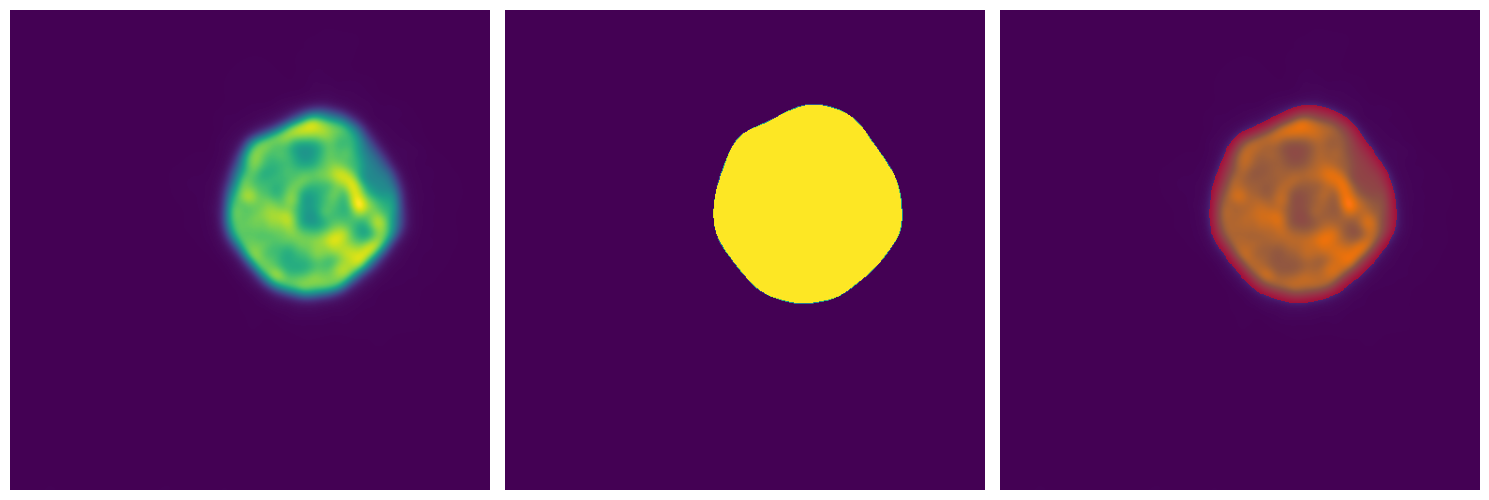

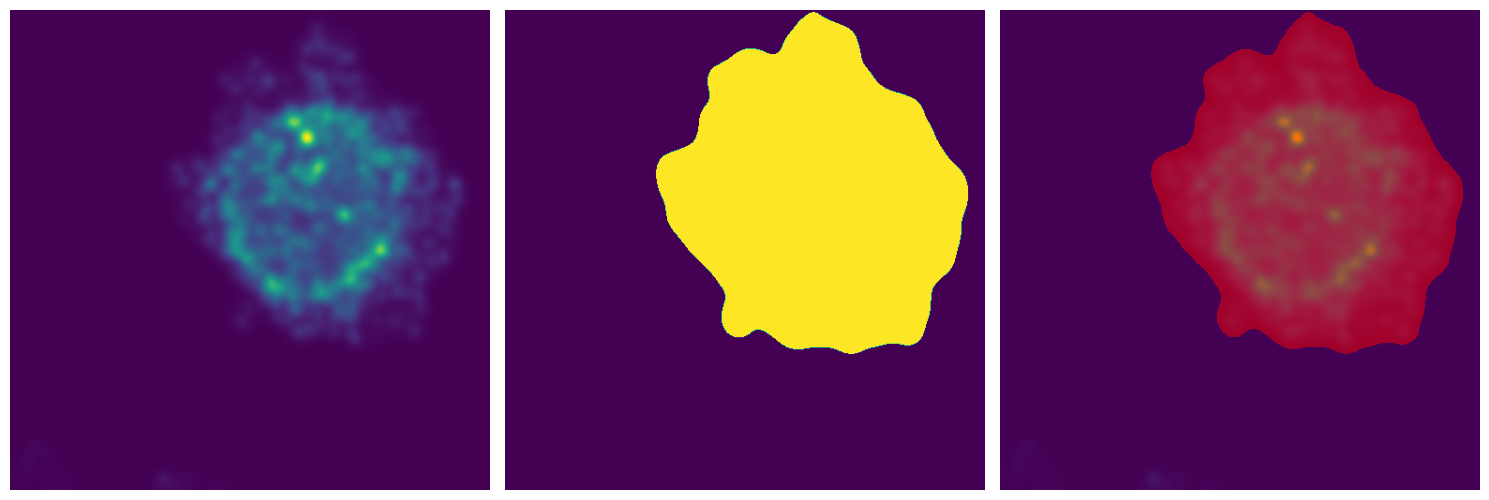

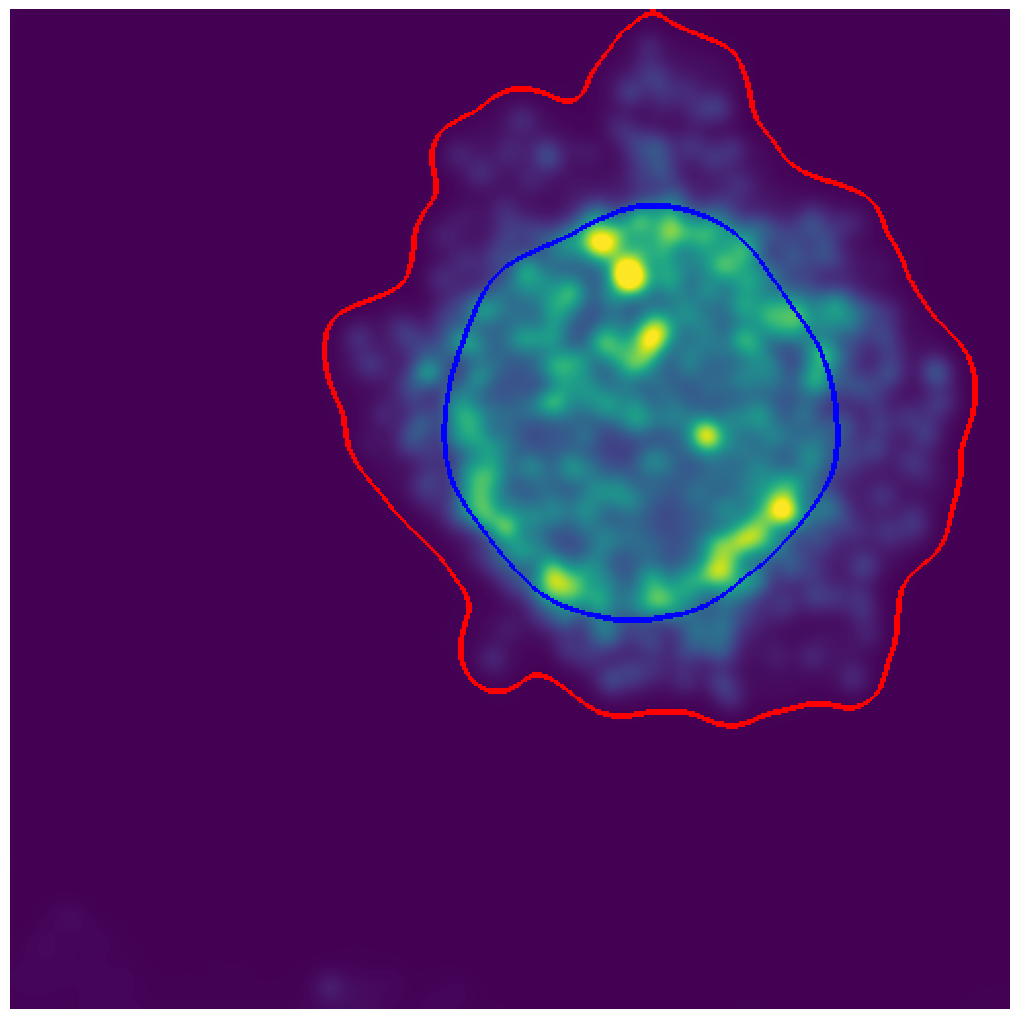

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_198.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_198.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_198.tif


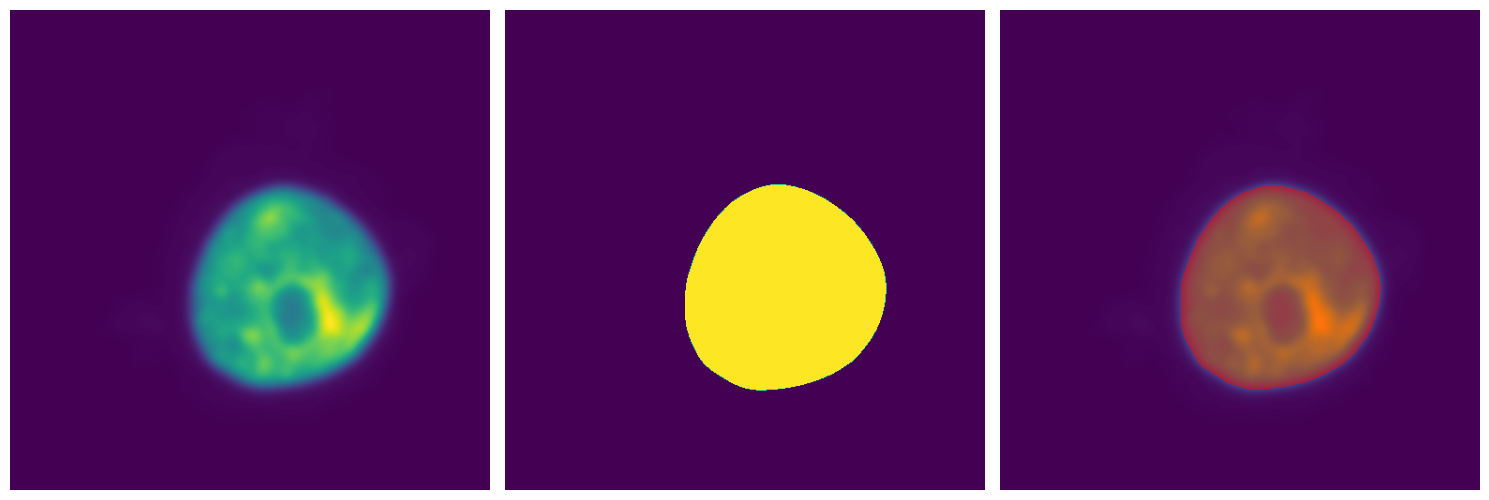

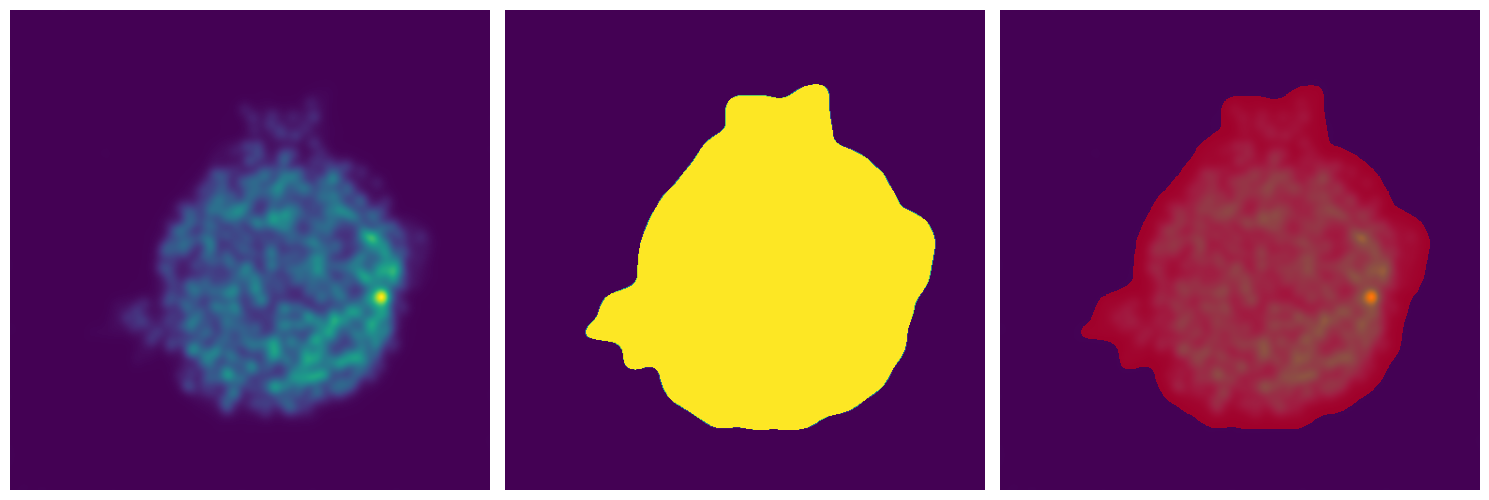

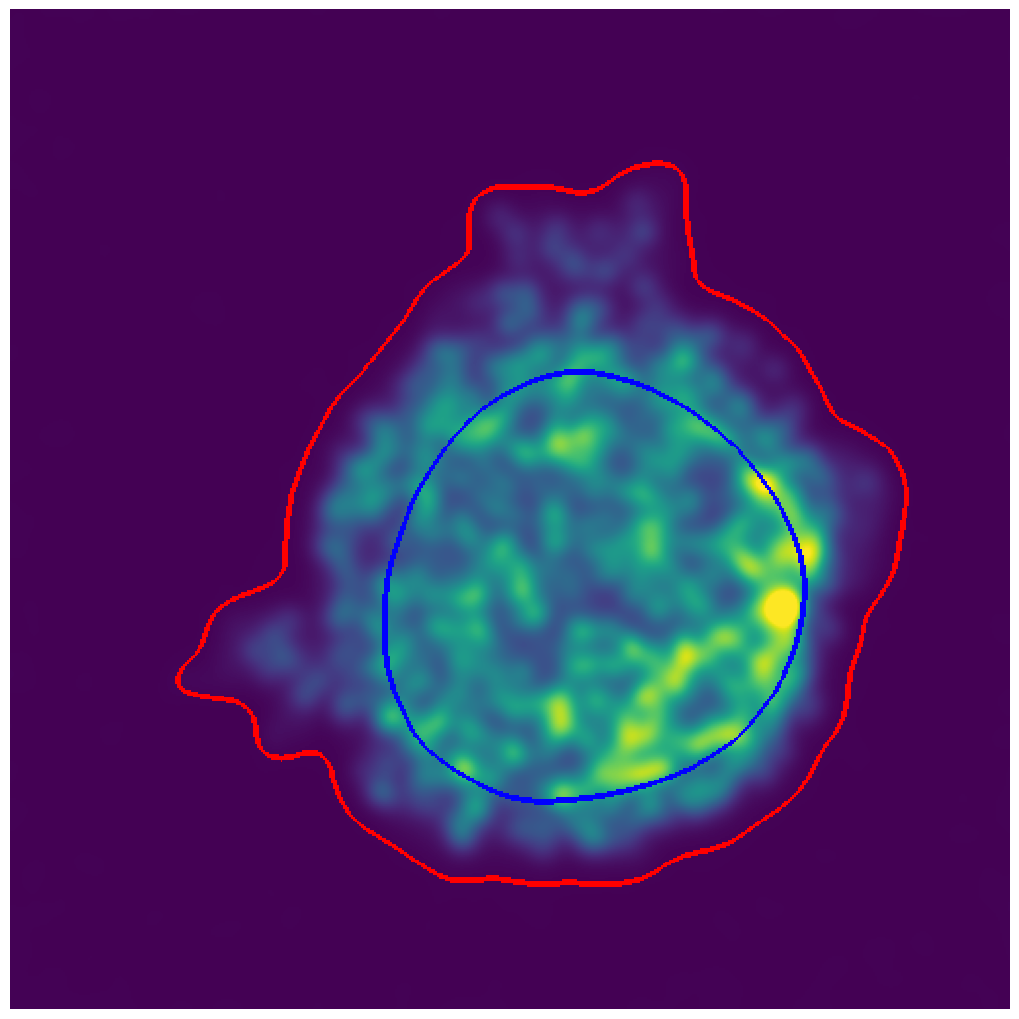

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_199.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_199.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_199.tif


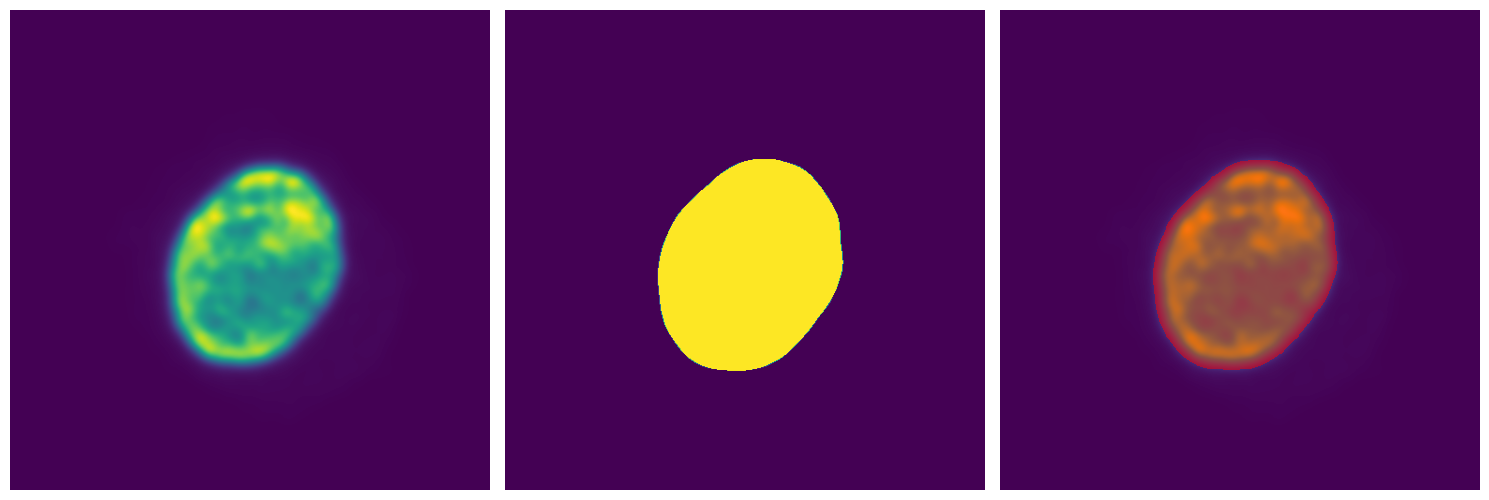

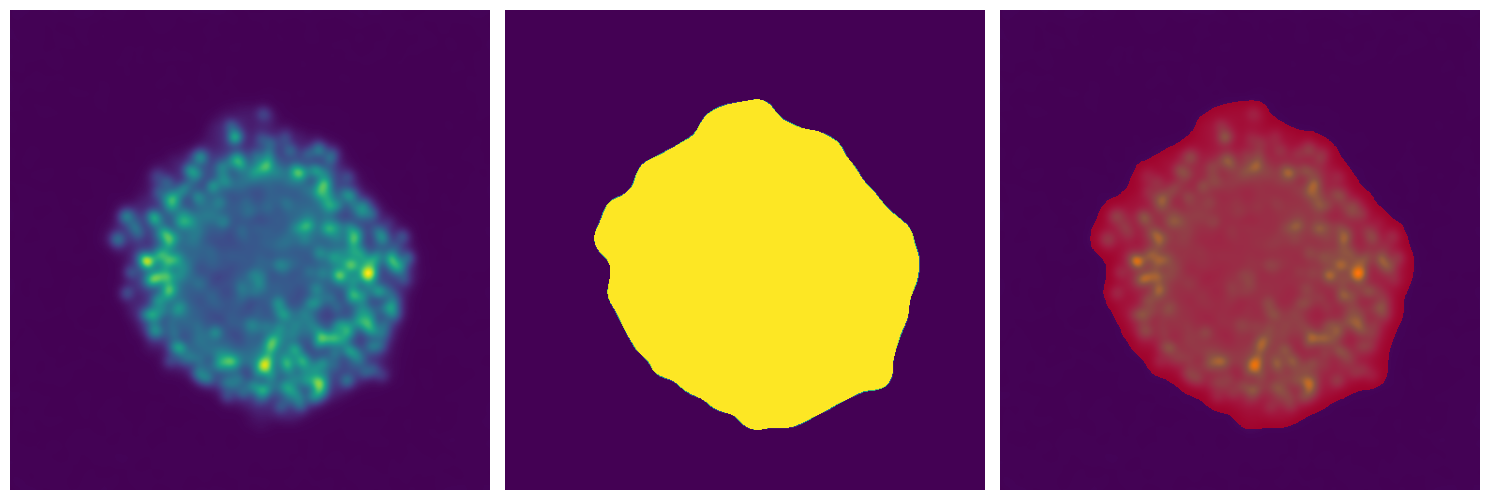

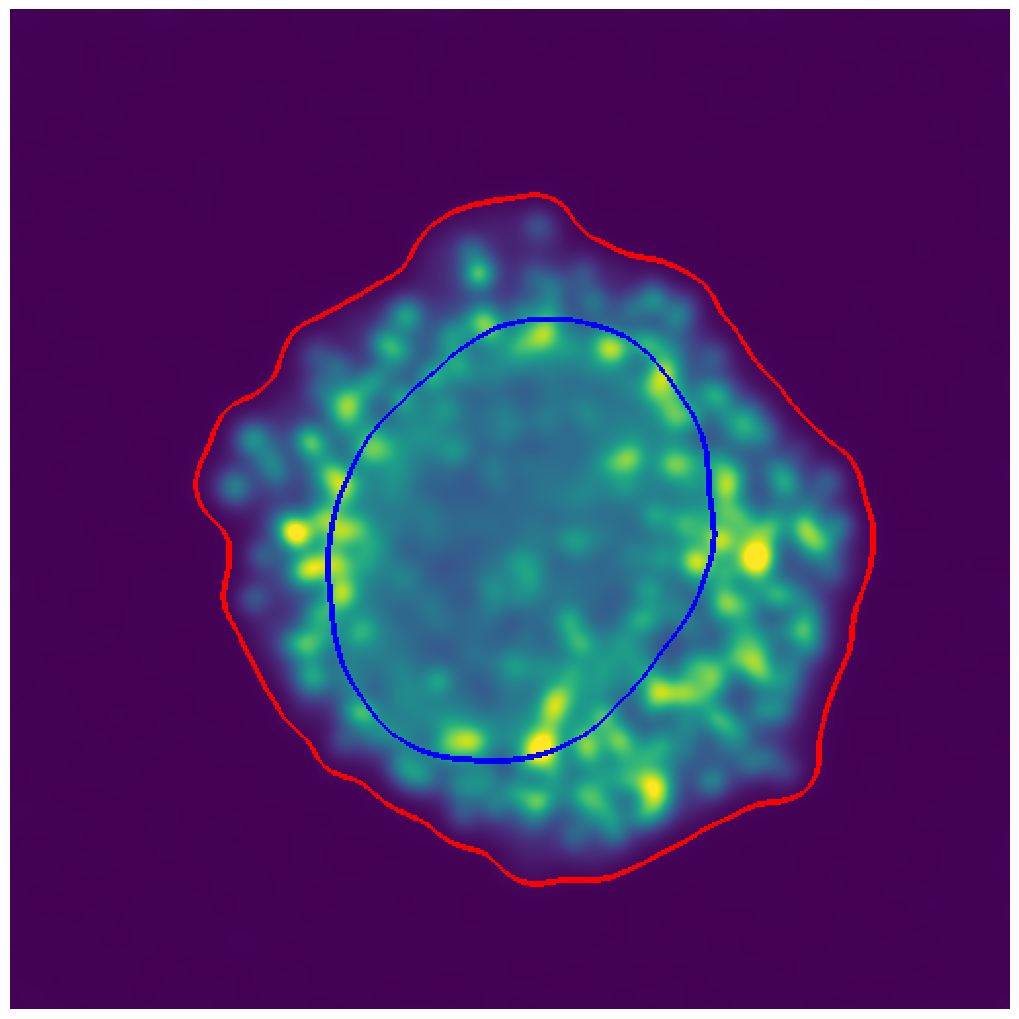

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Available DAPI channels:
171 - MCF7_AREG_KDM5-C70_171.tif_C1.tif
174 - MCF7_AREG_KDM5-C70_174.ti

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_200.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_200.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_200.tif


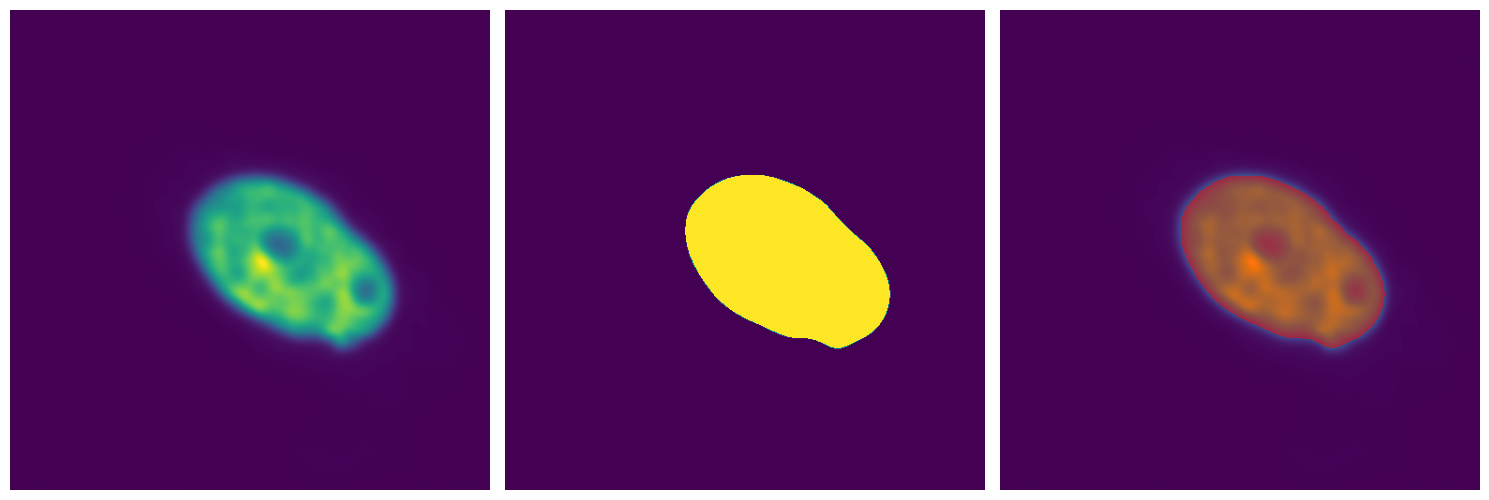

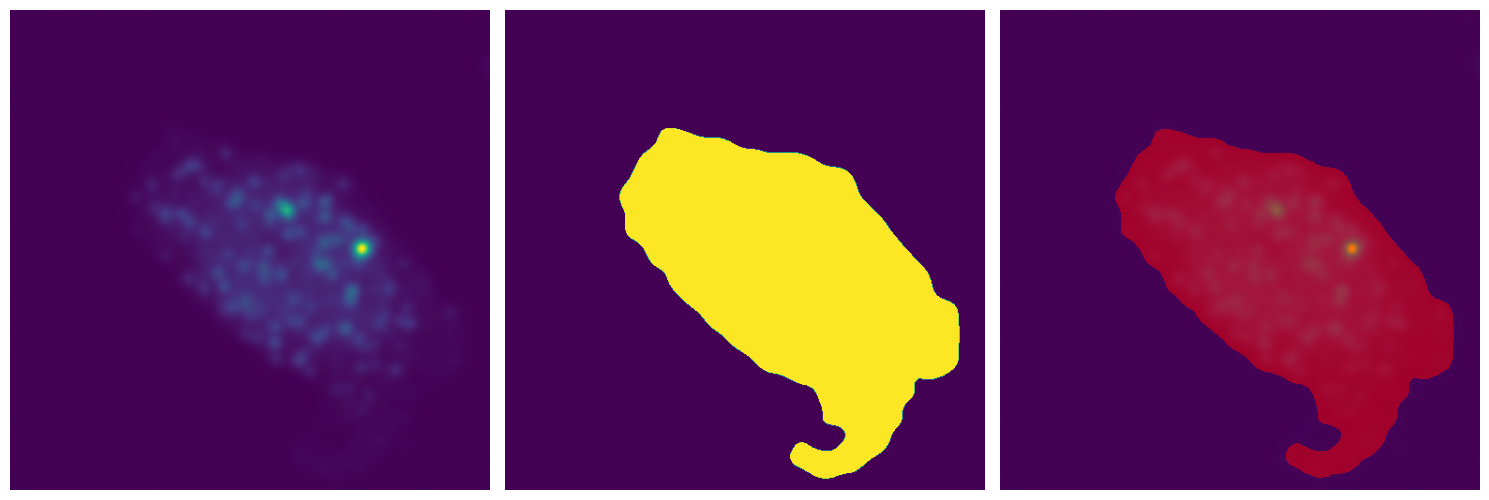

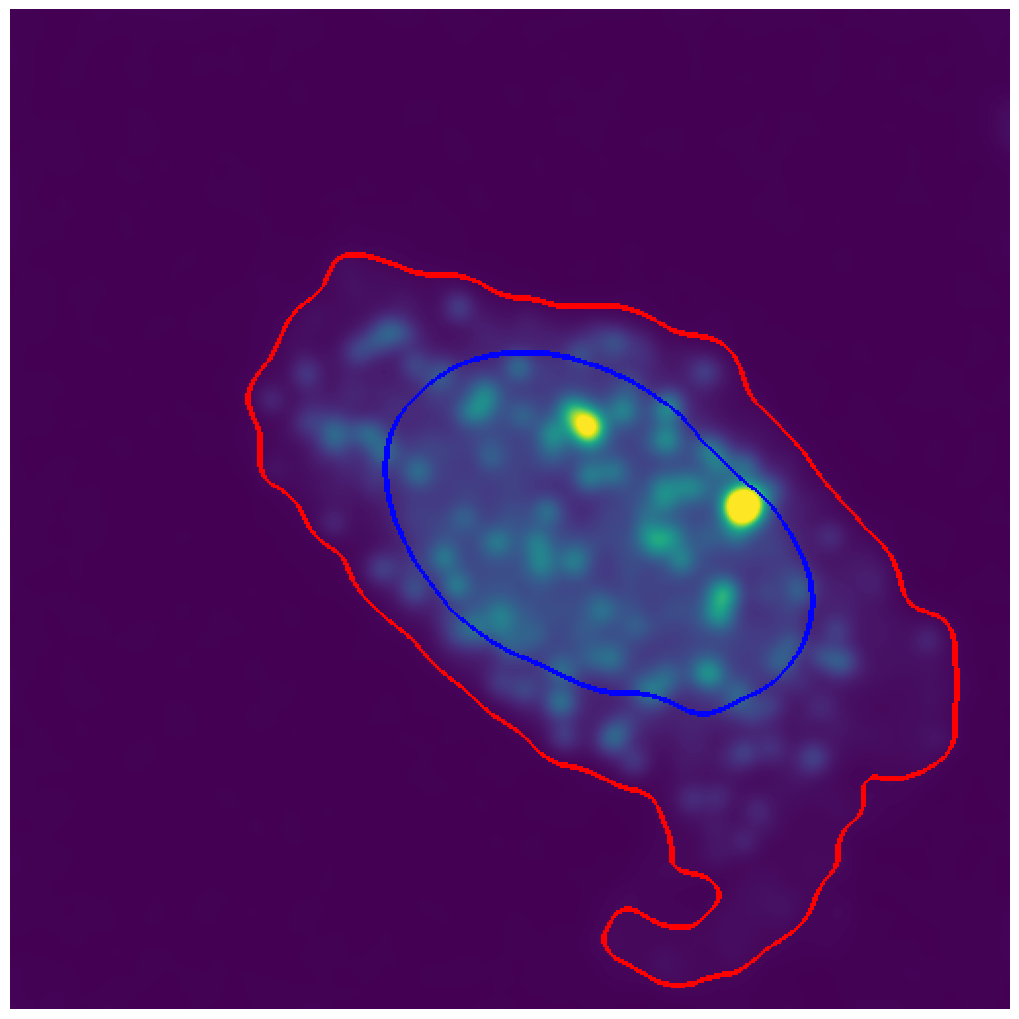

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): q


In [ ]:
#user can select nuclear/cellular segmentation on individual cell
if __name__ == "__main__":
    while True:
        path_input = choose_folder_colab()

        if path_input is None:
            break  # Exit the loop if 'q' is entered

        print(f"Selected folder: {path_input}")

        top_level_folder = os.path.basename(os.path.normpath(path_input))
        path_output = os.path.join(path_input, "output")

        if os.path.exists(path_output):
            subfolders = [f for f in os.listdir(path_output) if os.path.isdir(os.path.join(path_output, f))]

            if not subfolders:
                print("No subfolders found in the 'output' folder.")
                continue

            print("Subfolders:")
            for i, subfolder in enumerate(subfolders):
                print(f"{i + 1}: {subfolder}")

            selected_subfolder_index = int(input("Enter the number of the subfolder you want to select: ")) - 1

            if 0 <= selected_subfolder_index < len(subfolders):
                selected_subfolder = subfolders[selected_subfolder_index]
                os.chdir(os.path.join(path_output, selected_subfolder))

                dapi_channels = [f for f in os.listdir() if "_C1.tif" in f]
                fish_channels = [f for f in os.listdir() if "_C2.tif" in f]

                dapi_numbers = [extract_number_from_filename(channel) for channel in dapi_channels]
                fish_numbers = [extract_number_from_filename(channel) for channel in fish_channels]

                print("Available DAPI channels:")
                for i, (channel, number) in enumerate(zip(dapi_channels, dapi_numbers)):
                    print(f"{number} - {channel}")

                dapi_choice = int(input("Enter the number of the DAPI channel you want to select: "))
                if dapi_choice in dapi_numbers:
                  selected_dapi_channel = dapi_channels[dapi_numbers.index(dapi_choice)]
                  print(f"Selected DAPI channel: {selected_dapi_channel}")
                else:
                    print("Invalid DAPI channel selection. Please try again.")
                    continue

                print("Available FISH channels:")
                for i, (channel, number) in enumerate(zip(fish_channels, fish_numbers)):
                    print(f"{number} - {channel}")

                fish_choice = int(input("Enter the number of the FISH channel you want to select: "))
                if fish_choice in fish_numbers:
                  selected_fish_channel = fish_channels[fish_numbers.index(fish_choice)]
                  print(f"Selected FISH channel: {selected_fish_channel}")
                else:
                    print("Invalid FISH channel selection. Please try again.")
                    continue

                treatment = top_level_folder
                print(f"Selected treatment: {treatment}")
                print(f"DAPI Path: {os.path.join(path_output, 'splitted images', selected_dapi_channel)}")
                print(f"smFISH Path: {os.path.join(path_output, 'splitted images', selected_fish_channel)}")

                process_tiff_image(path_output, selected_dapi_channel, selected_fish_channel, dapi_choice, treatment)
            else:
                print("Invalid subfolder selection. Please try again.")
        else:
            print("No 'output' folder found in the selected path. Please choose a different folder.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of your Google Drive:
1: CV - D_Mitsea.pdf
2: Colab Notebooks
3: rf_final(1).ipynb
4: Random Forest 7_05.ipynb
5: Classroom
6: split channels.ijm
7: NOTEBOOK_6.cell extraction.ipynb
8: internship notebooks
9: notebook 4 WORKS WITH SPLITTING CHANNEL OUTPUT.ipynb
10: unet_saved_model
11: unet_painful_model
12: complex unet.ipynb
13: double_distance_model
14: metadata.csv.gsheet
15: DMSO MATLAB.csv
16: Matlab python comparison.ipynb
17: output_images_cell_MCF7_AREG_KDM5-C70_166.tif_C2.tif.png
18: KDM5-C70
Enter the number of the folder you want to select (q to quit): 18
Selected folder: /content/drive/MyDrive/KDM5-C70
Subfolders:
1: splitted images
2: nuclear masks
3: cellular masks
4: notebook 5 output
Enter the number of the subfolder you want to select: 1
Processing DAPI channel: MCF7_AREG_KDM5-C70_171.tif_C1.tif, Fish channel: MCF7_AREG_KDM5-C70_174

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_171.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_171.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_171.tif


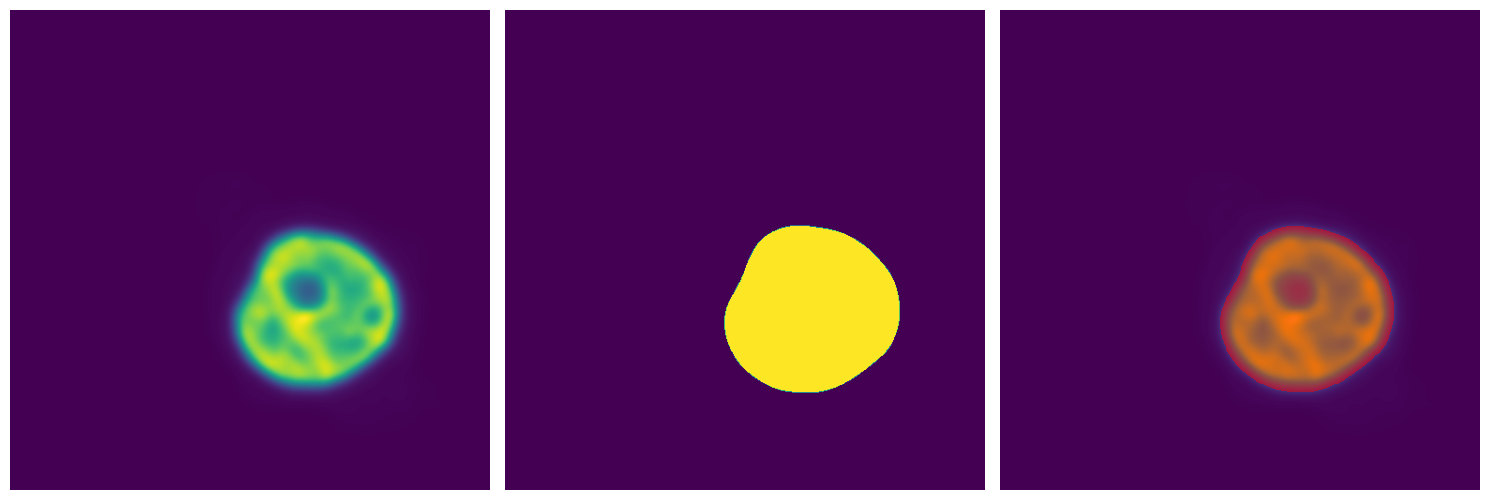

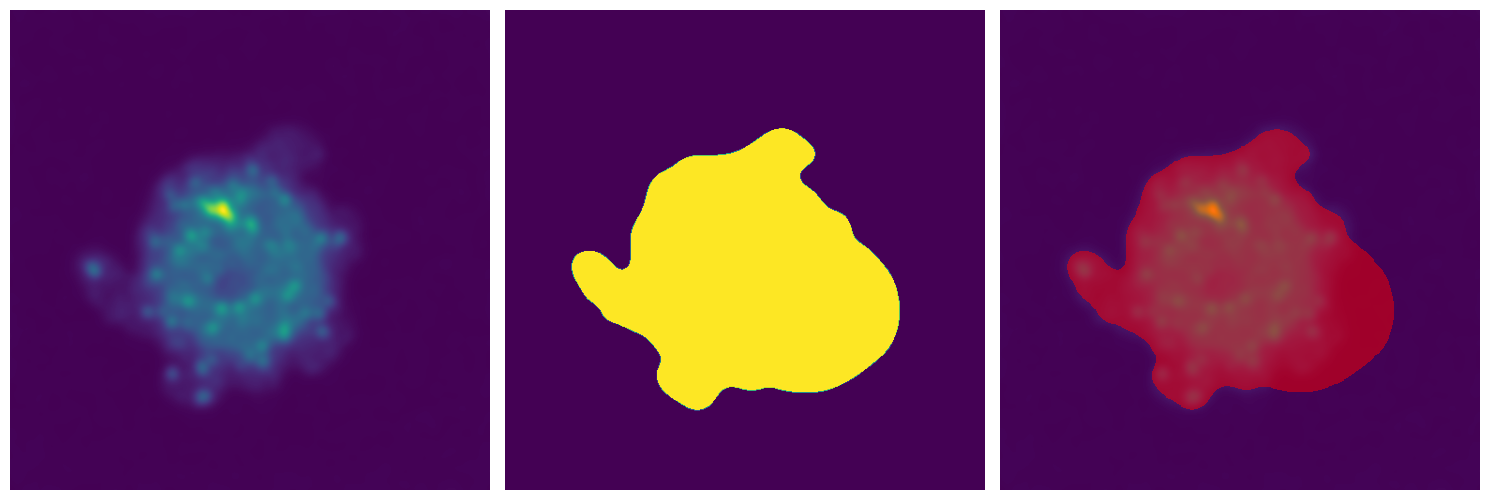

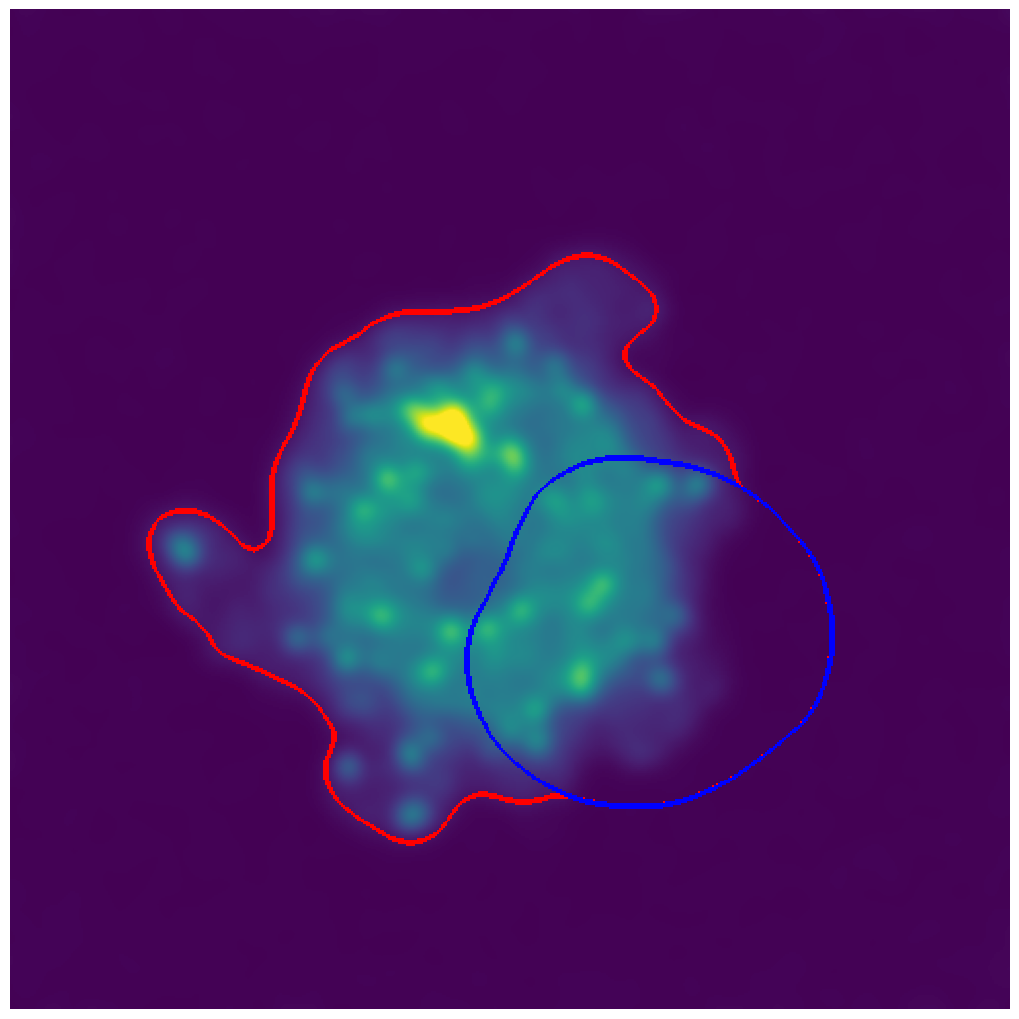

Processing DAPI channel: MCF7_AREG_KDM5-C70_174.tif_C1.tif, Fish channel: MCF7_AREG_KDM5-C70_172.tif_C2.tif
Extracted treatment: KDM5-C70
DAPI Path: /content/drive/MyDrive/KDM5-C70/output/splitted images/MCF7_AREG_KDM5-C70_174.tif_C1.tif
smFISH Path: /content/drive/MyDrive/KDM5-C70/output/splitted images/MCF7_AREG_KDM5-C70_172.tif_C2.tif


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Nuclear Label Array - Min: 0 Max: 1
Cellular Label Array - Min: 0 Max: 1
Processed image: MCF7_AREG_KDM5-C70_174.tif_C1.tif
Saved nuclear mask as /content/drive/MyDrive/KDM5-C70/output/nuclear masks/nuclear_mask_174.tif
Saved cellular mask as /content/drive/MyDrive/KDM5-C70/output/cellular masks/cellular_mask_174.tif


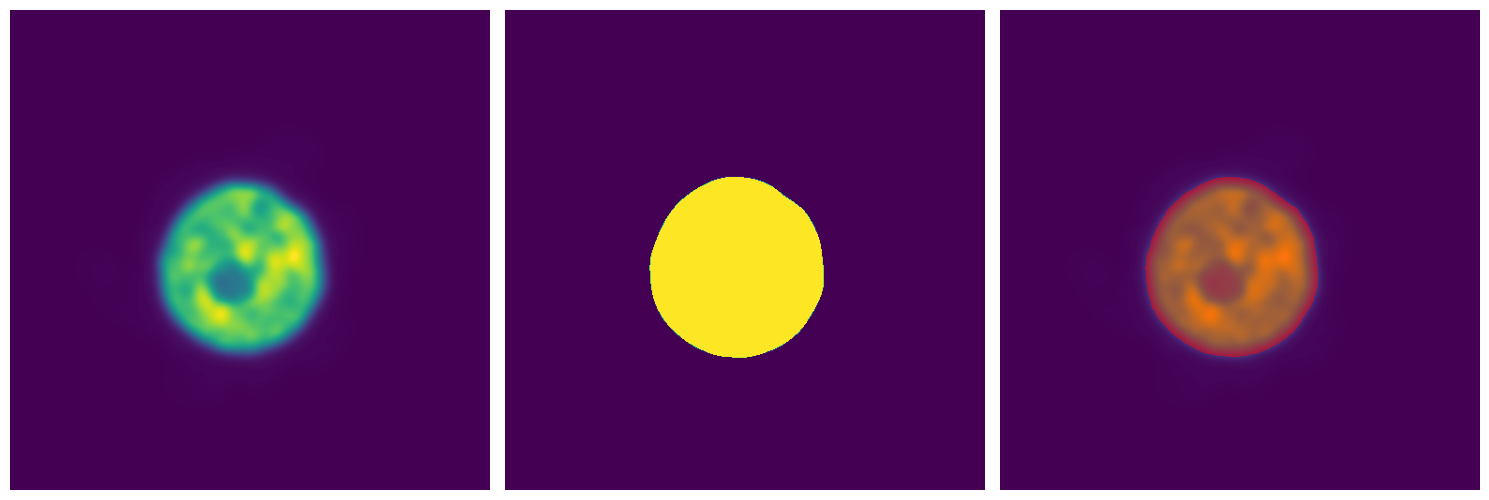

KeyboardInterrupt: 

In [ ]:
#user selects treatment and all nuclear and cellular masks for that treatment are extracted
if __name__ == "__main__":
    while True:
        path_input = choose_folder_colab()

        if path_input is None:
            break  # Exit the loop if 'q' is entered

        print(f"Selected folder: {path_input}")

        top_level_folder = os.path.basename(os.path.normpath(path_input))
        path_output = os.path.join(path_input, "output")

        if os.path.exists(path_output):
            subfolders = [f for f in os.listdir(path_output) if os.path.isdir(os.path.join(path_output, f))]

            if not subfolders:
                print("No subfolders found in the 'output' folder.")
                continue

            print("Subfolders:")
            for i, subfolder in enumerate(subfolders):
                print(f"{i + 1}: {subfolder}")

            selected_subfolder_index = int(input("Enter the number of the subfolder you want to select: ")) - 1

            if 0 <= selected_subfolder_index < len(subfolders):
                selected_subfolder = subfolders[selected_subfolder_index]
                os.chdir(os.path.join(path_output, selected_subfolder))

                dapi_channels = [f for f in os.listdir() if "_C1.tif" in f]
                fish_channels = [f for f in os.listdir() if "_C2.tif" in f]

                for dapi_channel, fish_channel in zip(dapi_channels, fish_channels):
                    dapi_numbers = extract_number_from_filename(dapi_channel)
                    fish_numbers = extract_number_from_filename(fish_channel)

                    print(f"Processing DAPI channel: {dapi_channel}, Fish channel: {fish_channel}")
                    process_tiff_image(path_output, dapi_channel, fish_channel, dapi_numbers, top_level_folder)

            else:
                print("Invalid subfolder selection. Please try again.")
        else:
            print("No 'output' folder found in the selected path. Please choose a different folder.")
